In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Overview

## 문제 정의
> 1912년 4월 15일 타이타닉호 침몰
> 총 2224명 중 1502명이 사망한 사건
- 문제 해결 목표: 생존-사망 데이터를 분석하여 생존 가능성이 더 높은 사람의 유형을 예측하는 모델 구축

## train.csv 데이터 셋 설명
- 탑승객의 일부(891명)에 대한 승객 정보
- columns
    - PassengerId: 승객 고유번호(int)
    - Survived: 생존 여부(int, 0: 사망, 1: 생존)
    - Pclass: 탑승권 등급(int, 1: 1st, 2: 2nd, 3: 3rd)
    - Name: 승객 이름(object(str))
    - Sex: 승객 성별(object(str))
    - Age: 승객 나이(float, 1보다 작으면 분수, 추정된 나이는 xx.5의 형태)
    - SibSp: 동승자 수-형제자매&부부(int, 단 정부나 약혼자는 제외) 
    - Parch: 동승자 수-부모자식(int, 단 유모와만 탄 아이는 0)
    - Ticket: 탑승권 번호(object(str))
    - Fare: 여객 요금(float)
    - Cabin: 선실 번호(object(str))
    - Embarked: 승선 항구(object(str), C: Cherbourg, Q: Queenstown, S: Southampton)

In [2]:
# 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check Data

In [3]:
# 데이터 로드
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# EDA

## 데이터 형태 파악
- train_df와 test_df의 차이: Survived 컬럼 유무, train_df는 지도학습을 위해 Survived 정보 있고, test_df는 예측을 위해 Survived 컬럼 없음<br/>
&rarr; target 변수: Survived
- train_df Null coloumns: 나이, 선실, 승선 항구
- test_df Null columns: 나이, 여객 요금, 선실

In [10]:
train_df.describe() # data type이 수치형인 변수들의 통계치

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Categorical 변수들 생존-사망 시각화
- Survived: target, 종속 변수, 0 or 1 categorical
- Pclass: 독립변수, 1 or 2 or 3 categorical
- Sex: 독립변수, male or female categorical
- Embarked: 독립변수, C or Q or S categorical
<br/><br/>
1. Survived 개수 -> 불균형 데이터 확인  
2. 독립변수에 따른 Survived 개수 -> 데이터 분포 확인

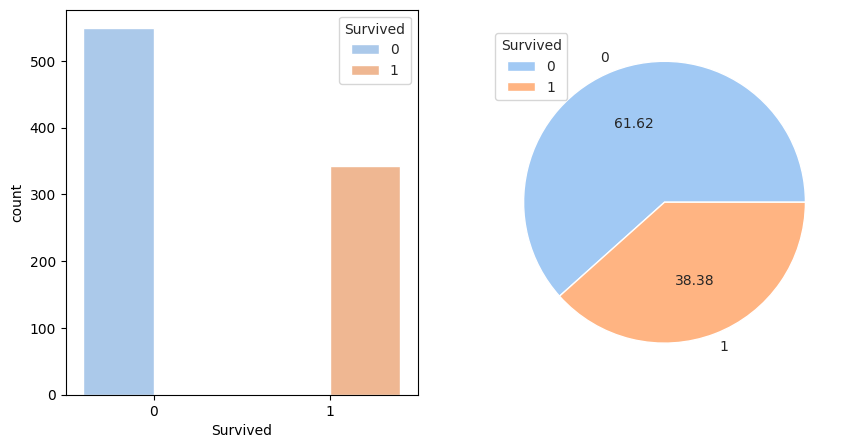

Survived
0    549
1    342
Name: count, dtype: int64


In [12]:
plt.figure(figsize=(10,5))
colors = sns.color_palette('pastel')

plt.subplot(1,2,1)
sns.set_style('whitegrid')
sns.countplot(train_df,x='Survived', hue = 'Survived', palette = colors)

plt.subplot(1,2,2)
plt.pie(train_df['Survived'].value_counts().values, labels = [0, 1], colors = colors, autopct = '%.2f' )
plt.legend(title='Survived')

plt.show()

print(train_df['Survived'].value_counts())

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


<Figure size 800x400 with 0 Axes>

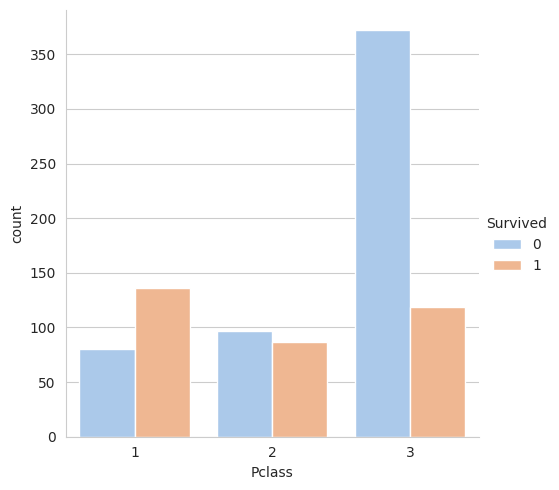

In [13]:
plt.figure(figsize=(8,4))

sns.set_style('whitegrid')
sns.catplot(train_df, x='Pclass', hue = 'Survived', palette = 'pastel', kind = 'count')
train_df.groupby(['Pclass','Survived']).size().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


<Figure size 800x400 with 0 Axes>

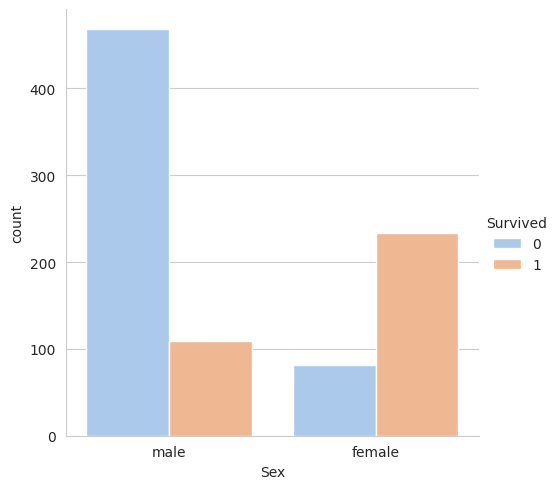

In [14]:
plt.figure(figsize=(8,4))

sns.set_style('whitegrid')
sns.catplot(train_df, x='Sex', hue = 'Survived', palette = 'pastel', kind = 'count')
train_df.groupby(['Sex','Survived']).size().unstack()

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


<Figure size 800x400 with 0 Axes>

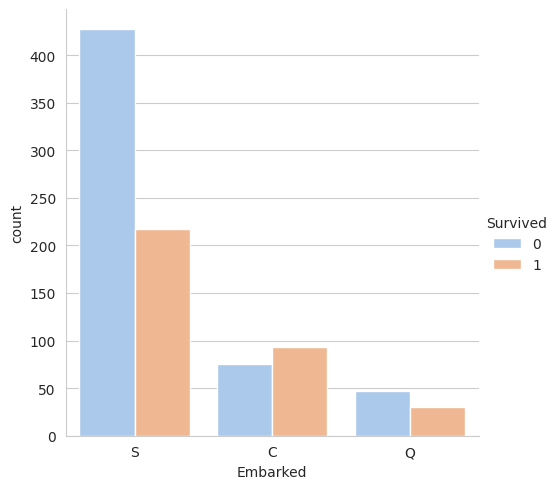

In [15]:
plt.figure(figsize=(8,4))

sns.set_style('whitegrid')
sns.catplot(train_df, x='Embarked', hue = 'Survived', palette = 'pastel', kind = 'count')
train_df.groupby(['Embarked','Survived']).size().unstack()

- Survived: 생존 < 사망, 둘의 데이터 크기 차이는 있으나 크지 않으므로 데이터 불균형 해소 과정(과적합 해결)은 이후 score 개선 단계에서 생각
- Pclass: 생존자의 탑승권이 1,2,3 등급인 크기는 비슷하나 3등급 탑승권의 사망자가 눈에 띄게 많으므로 해석할 필요가 있어보임, 변수 채택
- Sex: 성별에 따라 생존-사망의 패턴이 반대로 나타나므로 해석할 필요가 있어보임, 변수 채택
- Embarked: 셰르부르에서 승선한 탑승객의 생존-사망 패턴만 다름(근소하나 생존자 인원이 우위), 해석할 필요가 있어보임, 변수 채택

## 수치형 변수들 생존-사망 시각화

In [16]:
n_train_df = train_df.select_dtypes(include=np.number).iloc[:,[0,3,4,5,6]]
n_train_df.head()

,PassengerId,Age,SibSp,Parch,Fare
0,1,22.0,1,0,7.2500
1,2,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,4,35.0,1,0,53.1000
4,5,35.0,0,0,8.0500


- 이산형: PassengerId, Age,SibSp,Parch
- 연속형: Fare  
- PassengerId &rarr; 이후의 정보라 생존-사망과는 관련 없어보임 &rarr; 변수 제외  
\*참고, 모두 독립변수 
1. Survived가 사망(0)인 경우와 생존(1)인 경우의 각각의 변수 형태 확인
2. 이상치 데이터 확인
3. 이산형 변수 시각화는 히스토그램, boxplot 등으로...
4. 연속형 변수 시각화는 히스토그램(도수표작성), 분포 등으로...

<Axes: ylabel='Parch'>

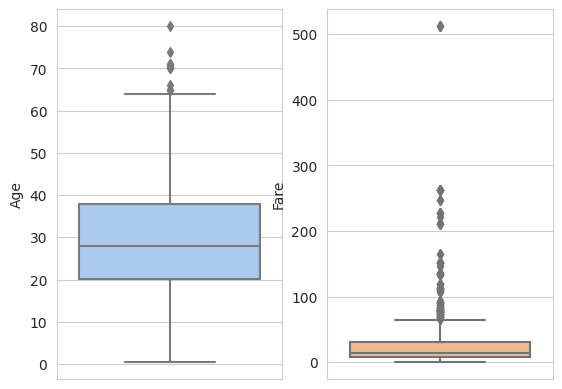

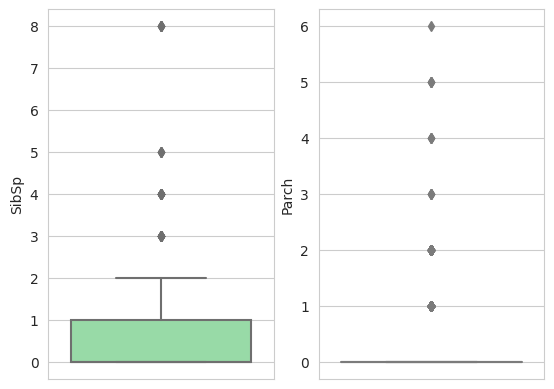

In [17]:
fig1, axes1 = plt.subplots(1,2)

sns.boxplot(y=n_train_df['Age'],color=colors[0],ax=axes1[0])
sns.boxplot(y=n_train_df['Fare'],color=colors[1],ax=axes1[1])

fig2, axes2 = plt.subplots(1,2)

sns.boxplot(y = n_train_df['SibSp'],color=colors[2],ax=axes2[0])
sns.boxplot(y = n_train_df['Parch'],color=colors[3],ax=axes2[1])


- 네 독립변수 모두 이상치 존재  
- SibSp와 Parch는 동승자에 대한 정보라는 점에서 공통점 존재, 동승자라는 새로운 변수 생성
- Fare는 Pclass과 함께 비용이라는 공통점이 존재(Pclass의 등급이 높을 수록 비용이 높을 것이라는 생각),   
  Fare를 Pclass와 마찬가지로 3개의 category로 범주화하여 이상치 해결
- Age는 이산형 데이터지만, 1살 미만의 아이와 정확한 나이를 모르는 사람은 소수점 이하 자리가 있는 실수형,  
  고령자의 인원이 별로 없어 이상치가 되는 점을 고려해 연령대 범주화로 해결

## Object(문자형) 변수들
- 데이터 타입이 object였던 변수 중, categorical이 아니어서 시각화하지 못한 변수들  
    : Name, Ticket, Cabin

In [18]:
train_df['Name'].iloc[:11], train_df['Name'].isnull().sum()

(0                               Braund, Mr. Owen Harris
 1     Cumings, Mrs. John Bradley (Florence Briggs Th...
 2                                Heikkinen, Miss. Laina
 3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
 4                              Allen, Mr. William Henry
 5                                      Moran, Mr. James
 6                               McCarthy, Mr. Timothy J
 7                        Palsson, Master. Gosta Leonard
 8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
 9                   Nasser, Mrs. Nicholas (Adele Achem)
 10                      Sandstrom, Miss. Marguerite Rut
 Name: Name, dtype: object,
 0)

In [19]:
train_df['Ticket'].iloc[50:60], train_df['Ticket'].isnull().sum()

(50       3101295
 51    A/4. 39886
 52      PC 17572
 53          2926
 54        113509
 55         19947
 56    C.A. 31026
 57          2697
 58    C.A. 34651
 59       CA 2144
 Name: Ticket, dtype: object,
 0)

In [20]:
train_df[train_df['Cabin'].notnull()]['Cabin'], train_df['Cabin'].isnull().sum()

(1              C85
 3             C123
 6              E46
 10              G6
 11            C103
           ...     
 871            D35
 872    B51 B53 B55
 879            C50
 887            B42
 889           C148
 Name: Cabin, Length: 204, dtype: object,
 687)

- Name: 대부분 '이름, 혼인여부. 성'의 형식, 혼인여부로 성별 판단 가능, 성으로 가족관계 유추 가능, 괄호 안의 정보는 무엇인지 불명확  
    &rarr; 성별에 대한 데이터(Sex)와 가족 관계(동승자)(SibSp,Parch)에 대한 데이터가 모두 존재하므로 이번 분석에서는 Name 변수 제외
- Ticket: 형식이 일관되지 않음(알파벳+숫자와 숫자 형식이 혼재), 탑승권은 탑승 등급(Pclass)와 여객 요금(Fare)의 정보를 담고 있을 것이라 생각, 이번 분석에서는 변수 제외
- Cabin: 형식은 '알파벳+숫자'로 일관되나 값이 1개가 아닌 데이터(index 872)가 존재, 또한 결측치가 과반수로 결측치 처리가 어려워 보임, 변수 제외

# 전처리(Preprocessing)

## 필요한 전처리 내용
- 라벨링
    - Sex, Embarked
- 결측치 처리
    - Age, Embarked, Fare(test에만 있음->모델 제출 시에는 결측치 제거 함수 필요할 듯)
- 이상치 처리
    - Age, Fare, SibSp, Parch

#### 라벨링

In [21]:
# {'male':0, 'female':1}
train_df['Sex'] = train_df['Sex'].apply(lambda x: 0 if x == 'male' else 1)

In [22]:
train_df['Embarked'].value_counts(), train_df['Embarked'].isnull().sum()

(Embarked
 S    644
 C    168
 Q     77
 Name: count, dtype: int64,
 2)

In [23]:
# 결측치를 갖는 데이터 2개는 최빈값인 S에 할당 {'C':0, 'S':1, 'Q':2}
train_df['Embarked'] = train_df['Embarked'].apply(lambda x: 0 if x == 'C' else (1 if x == 'S' else (2 if x == 'Q' else 1)))

#### 이상치 처리

In [24]:
max(train_df[train_df['Age'].notnull()]['Age'].values)

80.0

<Axes: xlabel='Age', ylabel='Count'>

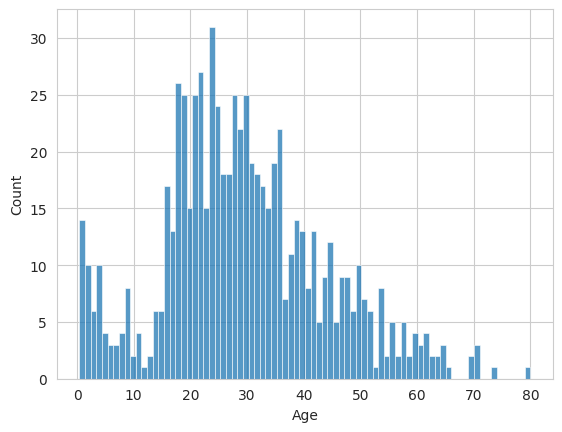

In [25]:
# Age histogram 보기
sns.histplot(train_df['Age'], bins = 80)

In [26]:
train_df['Age'].isnull().sum()

177

In [27]:
# Age 변수의 결측치를 평균 나이로 처리
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())

In [28]:
# 연령대 나누기: {0-10:0, 10-20:1, 20-30:2, 30-40:3, 40-50:4, 50-:5}
train_df['Age'] = train_df['Age'].apply(lambda x: x//10 if x < 50 else 5)

<Axes: ylabel='Fare'>

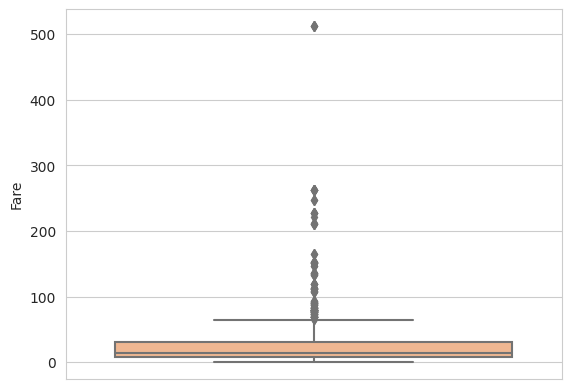

In [29]:
# Fare 이상치 확인
sns.boxplot(y=n_train_df['Fare'],color=colors[1])

<Axes: ylabel='Fare'>

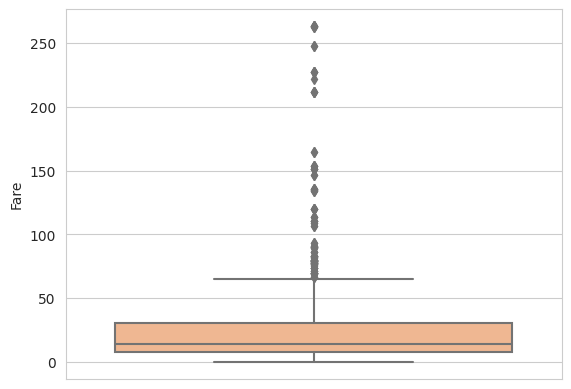

In [30]:
# 유독 눈에 띄는 데이터 제외 후 다시 이상치 확인
a = train_df[train_df['Fare'] != max(train_df['Fare'].values)]
sns.boxplot(y=a['Fare'],color=colors[1])
# 결과: 여전히 이상치 많음 -> 범주화 시도

<Axes: xlabel='Fare', ylabel='Density'>

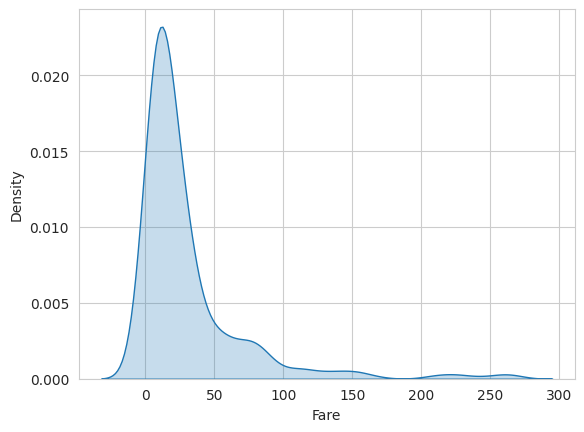

In [31]:
sns.kdeplot(a['Fare'],fill=True)

In [32]:
# 분포가 몰린 관계로 일정 비율로 Fare 범주화 (요금과 관계있어 보이는 Pclass가 등급이 3개이므로 3분할) {'low':0, 'mid':1, 'high':2}
train_df['Fare'] = pd.qcut(train_df['Fare'],3,labels=[0,1,2])

<Axes: xlabel='Parch', ylabel='Count'>

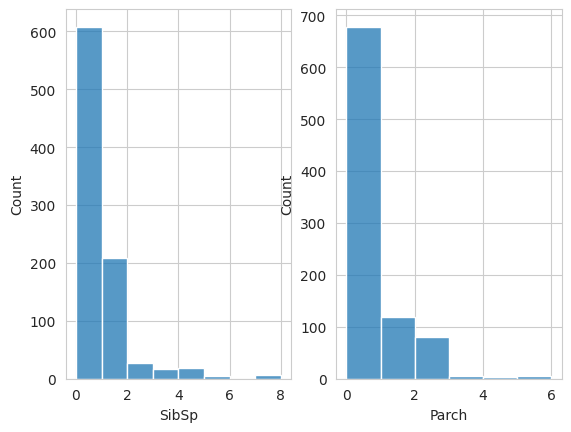

In [33]:
# SibSp와 Parch histogram 보기
fig, axes = plt.subplots(1,2)

sns.histplot(train_df['SibSp'], bins = 8,ax = axes[0])

sns.histplot(train_df['Parch'], bins = 6, ax = axes[1])

<Axes: >

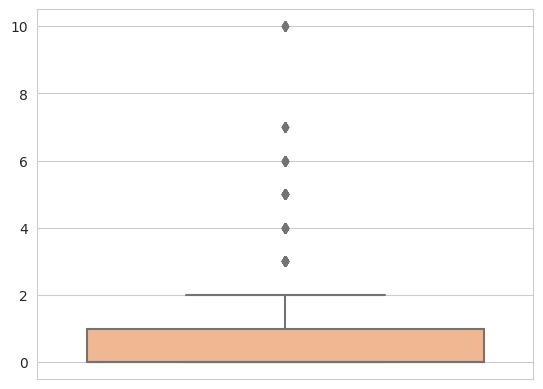

In [34]:
# 동승자 수 구하고 시각화
total = train_df['SibSp']+train_df['Parch']
sns.boxplot(y=total,color=colors[1])
# 결과: 이상치 여전함 -> 카테고리컬..?